## Scope
Read, inspect, annotate output of AtoMx software for 1 or more CosMx slides.  
Aim: visualise FOVs, visualise cells, QC experiment, identify wich FOVs belong to which sample. Used to generate 'FOV_mapping.tsv'

#Inputs:
One or more folders "Exp1", "Exp2".. each containing 3 .csv outputs
- counts_file : ExpN/ExpN_exprMat_file.csv
- meta_file : ExpN/ExpN_metadata_file.csv
- fov_file : ExpN/ExpN_fov_positions_file.csv

- "slide_mapping.tsv" file  
containing the mapping of the different slides "Experiment1", "Experiment2"... i.e. the info of which samples are on which slide. For example: 
name	folder	time_point	individual	tissue	dataset
projX_1	Experiment1	TP1	i2	spleen	cosmX
projX_2	Experiment2	TP2	i1	spleen	cosmX
Note: rename as e.g. "projX_1" as "Experiment1" may be a very long string and/or not unique
Batch-level information, such as time point, individual, tissue, dataset.. info are used to annotate the AnnData for later integration

- "IF_images/ExpN_IF.jpg" (optional)  
This is the immuno-fluorescence picture of the tissue. It will be used as background during plotting of FOVs. The image should have the same (0,0) coordinates as the FOVs.  

#Outputs:  
The mapping file 'FOV_mapping.tsv' will be generated during the workflow. It contains the info of which FOV belongs to which sample on the slide  
name	folder	id	FOV_idx	time_point	mouse	tissue	dataset  
projX_1	ThomasOttoMouseSlide1060324	1	1	TP_2	m1	spleen	cosmX  
projX_1	ThomasOttoMouseSlide1060324	1	2	TP_2	m1	spleen	cosmX  


## Instructions  
Run the jupyter notebook inside the environment (see dependencies to create and activate).  
The importer script if modified from Squidpy. This is a quick and dirty fix that changed 2 files inside the package to "add" a function "sq.read.nanostring_mod" to the read library and reference it in __init__.py. Copy those 2 files in ~/miniforge3/envs/YOURENV/lib/python3.10/site-packages/squidpy/read



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import os

import squidpy as sq

import warnings
warnings.filterwarnings('ignore')

/home/adnane/miniforge3/envs/scrnaseq3.10/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
def read_cosmx(folder, sample, slide):
    # this is a modified version of the importer script
    # it uses an ad hoc script added to squidpy (quick and dirty) to be able to call it as part of the package
    # cp __init__.py ~/miniforge3/envs/scrnaseq3.10/lib/python3.10/site-packages/squidpy/read
    # cp _read_mod.py ~/miniforge3/envs/scrnaseq3.10/lib/python3.10/site-packages/squidpy/read
    return sq.read.nanostring_mod(
        path =  f"{folder}/{sample}/",
        slide = slide, 
        counts_file = sample + "_exprMat_file.csv",
        meta_file = sample + "_metadata_file.csv",
        fov_file = sample + "_fov_positions_file.csv",
        )

In [18]:
def plot_fovs_to_slide(pos_file, img_file):
    
    coords = pd.read_csv(pos_file)
    fov_key="fov" #"FOV"
    xkey = "x_global_mm" # "Y_mm"
    ykey = "y_global_mm"  # "X_mm"

    coords[fov_key] = coords[fov_key].astype(str)
    coords["in_metaexpr"] = (coords[fov_key].str.replace("^",slide + "_", regex=True).isin(adata.uns["spatial"]))
    ffovs, totfovs = sum(coords["in_metaexpr"]), len(coords["in_metaexpr"])
    print(f"Found {ffovs} FOVs in metadata out of {totfovs} FOVs in positions file")
    
    col = np.where(coords["in_metaexpr"], "cyan" , "red" )

    figure, ax = plt.subplots()
    ax.scatter(coords[xkey], coords[ykey] , s=30, alpha=0.36, marker="s", c=col)
    for idx, row in coords.iterrows():
            ax.annotate(row[fov_key], (row[xkey], row[ykey]) , 
                        textcoords="offset points", xytext=(-1,-1), 
                        fontsize=3, fontweight="bold", fontfamily="sans-serif", color="white" )
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    print(xmin, xmax, ymin, ymax)
    #plt.imshow(plt.imread(img_file),zorder=0, extent=[xmin, xmax, ymin, ymax])  
    img_out= f"{sample_dir}IF_images/{slide}_fov_positions.from.csv.png"
    figure.savefig(img_out, format="png", dpi=900)

## Start workflow here

In [5]:
sample_dir = "/mnt/share/Projects/Proj_AN3_Brain/"
mapping_f = "FOV_mapping_brain_v1.tsv"
mapping_s = "slide_mapping_brain.tsv"

conditions = pd.read_csv(sample_dir + mapping_s, header=0, sep="\t")
slide_list = conditions["name"].unique()
print(slide_list)
iter_slides = iter(slide_list)
pm = {}

['Brain1']


## Looping across the slides - ITERATE FROM HERE

In [7]:
slide = next(iter_slides)

folders = conditions[conditions["name"] == slide]["folder"].unique()
if len(folders) == 1 :
    slide_orig = folders[0]
else :
    print("Too many or too few working directories were parsed") 

print("Processing slide ", slide) 

pos_file = f"{sample_dir}{slide_orig}/{slide_orig}_fov_positions_file.csv"
img_file = f"{sample_dir}IF_images/{slide}_IF.jpg"

Processing slide  Brain1


Step 1. Reading metadata file
Step 2. Reading counts file
Step 3. Generating counts sparse matrix with correct columns
	Common index length :  221011
Step 4. Generating AnnData
Step 5. Reading image directories if existing
	No  CellComposite image directory in output. Skipping.
	No  CellLabels image directory in output. Skipping.
Step 6. Reading fov file
AnnData object with n_obs × n_vars = 221011 × 6519
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.Histone', 'Max.Histone', 'Mean.G', 'Max.G', 'Mean.rRNA', 'Max.rRNA', 'Mean.GFAP', 'Max.GFAP', 'Mean.DAPI', 'Max.DAPI', 'SplitRatioToLocal', 'NucArea', 'NucAspectRatio', 'Circularity', 'Eccentricity', 'Perimeter', 'Solidity', 'cell_id', 'assay_type', 'version', 'Run_Tissue_name', 'Panel', 'cellSegmentationSetId', 'cellSegmentationSetName', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', '

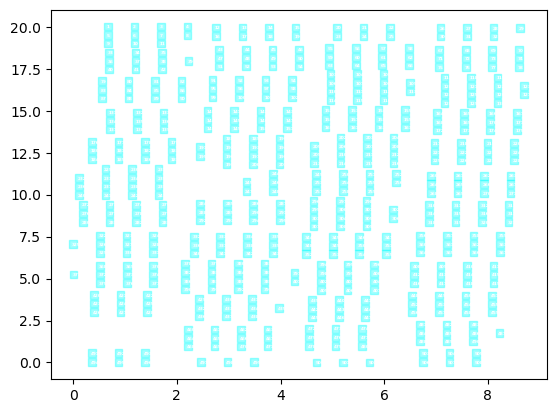

In [20]:
## Reading slide files
# and finding which FOVs are on which tissue
adata = read_cosmx(sample_dir, slide_orig, slide)
print(adata)

# check positions of fovs on the slide to select appropriately which fovs correspond to which sample
# this a partly to fix a bug of AtoMx export that reindexes and shuffles fovs numbers irrespective of the numbers
# selected by the user
# in red are FOVs that exist in positions file but have no counts or metadata, due to failing QC in AtoMx 
# and being discarded
# the background image needs to be in the same coordinate system (same 0 and max for x and y) as the fov positions, i.e. not cropped, but expanded is OK
plot_fovs_to_slide(pos_file, img_file)

# The resulting mapping file is then created manually from what is shown on the picture

In [24]:
in_hd5f = slide_orig + "_raw.hdf5"
os.makedirs(f"{sample_dir}{slide}", exist_ok = True)
adata.write(filename= f"{sample_dir}{slide}/{in_hd5f}")

## next section not required  
as one can now switch to Seurat import of .rds file to annotate FOVs using the mapping file, split/subset the object based on batch-level infos etc..

In [ ]:
def annotate_fovs(mapping_file, adata, slide, slide_orig):
    
    adata.obs["slide_name"] = slide 
    
    mapping = pd.read_csv(mapping_file, header=0, sep="\t")
    fltr_mapping = mapping[ (mapping["name"] == slide) & (mapping["folder"] == slide_orig ) ]
      
    for idx, row in fltr_mapping.iterrows():
        up_list = ["sample" , "time_point", "mouse", "tissue", "dataset" ]
        in_list = [ row["folder"], row["time_point"], row["mouse"], row["tissue"], row["dataset"] ]
        adata.obs.loc[ adata.obs["fov"] == str(row["FOV_idx"]) , up_list ] = in_list
        
    return adata

In [ ]:
def split_anndata(slides_meta_file, adata, slide, slide_orig):
    
    conditions = pd.read_csv(slides_meta_file, header=0, sep="\t")
    fltr_conditions = conditions[ (conditions["name"] == slide) & (conditions["folder"] == slide_orig ) ]
    
    for idx, row in fltr_conditions.iterrows():
        tgt_tp , tgt_tis, tgt_mo = row["time_point"], row["tissue"], row["mouse"]      
        
        name = "_".join([tgt_tp ,tgt_mo, tgt_tis])
        tgt_file = f"{sample_dir}{slide}/{name}_raw.hdf5"
        print(f"=========================\tWriting {name} to {tgt_file}")
        
        subdata = adata[ (adata.obs["time_point"] == tgt_tp) &
            (adata.obs["tissue"] == tgt_tis) &
            (adata.obs["mouse"] == tgt_mo) ]
                        
        print(subdata)              
        subdata.write(filename= tgt_file)

In [ ]:
# use picture from previous cell to generate FOV_mapping.tsv file by hand
annotate_fovs(sample_dir + mapping_f, adata , slide, slide_orig)
print(adata.obs)

# Subsetting dataframe by FOV
os.makedirs(f"{sample_dir}{slide}", exist_ok = True)
split_anndata(sample_dir + mapping_s, adata , slide, slide_orig)